In [13]:
from tqdm.contrib import itertools
from simulation_util import calc_frequency

In [14]:
from EduKTM import DKT
import torch
import torch.utils.data as Data
from dkt.loader import transform_sim_data, parse_all_seq, encode_onehot

NUM_QUESTIONS = 9
HIDDEN_SIZE = 100
NUM_LAYERS = 3
BATCH_SIZE = 64

dkt = DKT(NUM_QUESTIONS, HIDDEN_SIZE, NUM_LAYERS)
dkt.load("./dkt/dkt.params")
model = dkt.dkt_model
model.eval()


def create_task_with_kt_model(simulation_log, dql_model):
    transformed_data = transform_sim_data(simulation_log, dql_model).dropna(subset=['skill_id'])
    data = parse_all_seq(transformed_data)
    encoded = encode_onehot(data, NUM_QUESTIONS)
    data_loader = Data.DataLoader(encoded, shuffle=True)
    
    for batch in data_loader:
        integrated_pred = model(batch.to(torch.float32))
        task_count = integrated_pred.shape[1]
    return {
        category: [
            calc_frequency(integrated_pred[0][task_count-1][(category_i * len(dql_model[category])) + i].item()) for i in range(len(dql_model[category]))
        ] for category_i, category in enumerate(dql_model)
    }




In [ ]:
from simulation_util import add_delta_to_competency, calc_task_complexities, calculate_delta, create_learner_population, create_random_task
from simulation_const import DQL_MODEL

MAX_TASK_COUNT = 100

def simulate_task_adaptation(learner_count: int, mean_competency: float, bonus_distribution: tuple[4]):

    learner_population = create_learner_population(
        learner_count, MAX_TASK_COUNT, DQL_MODEL, mean_competency, bonus_distribution)

    simulationLog = []

    for i, j in itertools.product(range(MAX_TASK_COUNT), range(learner_count)):
        learner_competency = learner_population["learner_competencies"][j]

        scaffolding_bonus = learner_population["scaffolding_competence_bonus_per_step_and_learner"][i][j]
        
        # task = create_optimal_task(
        #     DQL_MODEL, learner_competency, scaffolding_bonus)
        if(j == 0):
            task = create_random_task(DQL_MODEL)
        else:
            task = create_task_with_kt_model([simulationLog[j-1]], DQL_MODEL)

        task_complexities = calc_task_complexities(task)
        delta = calculate_delta(
            learner_competency, task_complexities, scaffolding_bonus)

        # update the learner competency in the global learner population
        learner_population["learner_competencies"][j] = add_delta_to_competency(
            learner_competency, delta)    

        simulationLog.append({
            "tasks": [],
            "competencies": [],
            "scaffolding_bonuses": [],
            "deltas": []
        })
        simulationLog[j]["tasks"].append(task)
        simulationLog[j]["competencies"].append(learner_competency)
        simulationLog[j]["scaffolding_bonuses"].append(scaffolding_bonus)
        simulationLog[j]["deltas"].append(delta)
            
            

    return simulationLog

100%|██████████| 1000/1000 [00:00<00:00, 67791.11it/s]


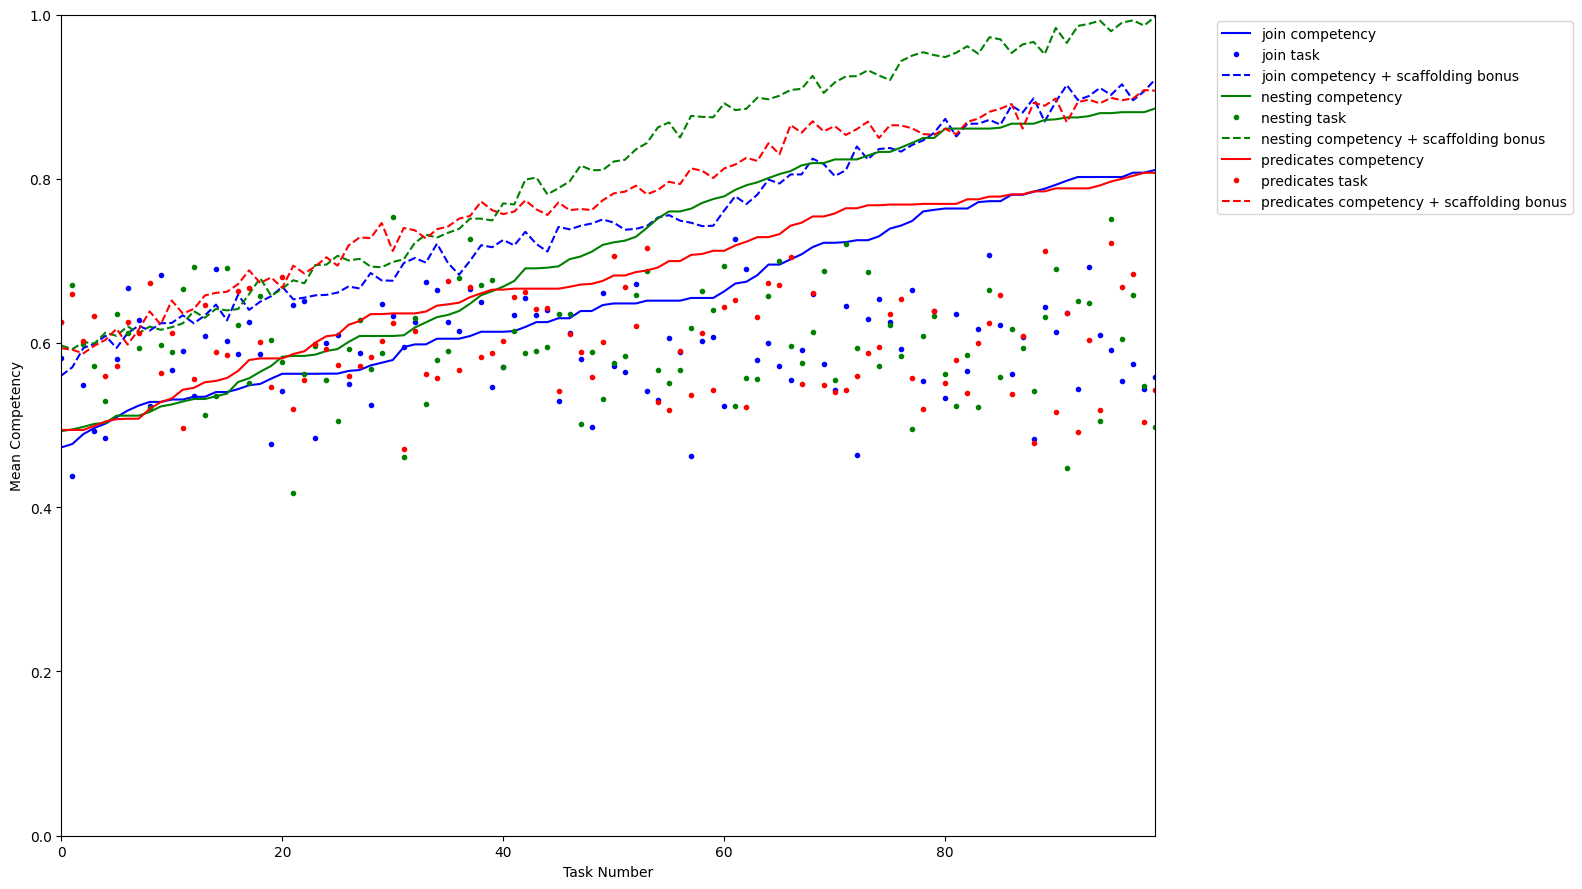

In [16]:
from simulation_plot import plot_mean_simulation_log

log = simulate_task_adaptation(10, 0.5, (0.1, 0.002, 0, 0.2))

plot_mean_simulation_log(log)